# Clasificación de expresiones de los rostros

Vamos a descomprimir el archivo que contiene el dataset de las imagenes de rostros por medio de 


```
!unzip
```



In [ ]:
ruta='/content/drive/MyDrive/Analitica_de_datos/Analisis_de_expreciones_CNN/Data_set_faces_feels.zip'
!unzip ruta

In [ ]:
import pandas as pd #nos ayuda a manejar los datos

#tensor flow y kerans para la creación de la red neuronal
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets,layers,models

#nos ayudará a graficar y visualizar la data
import matplotlib.pyplot as plt
import numpy as np

#nos ayuda al manejo de archivos
import os
#paqueteria para que aparezca una barra de carga en las imagenes
from tqdm import tqdm

#nos ayuda a transformar las imagenes
import cv2
from glob import glob

#importo de keras algunas capas mas que son necesarias para este modelo
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.optimizers import Adam, RMSprop, SGD, Adagrad
#nos ayudara a separar la data de entrenamiento y la data de prueba
import sklearn
from sklearn.model_selection import train_test_split

#Manejo de imagenes
import skimage
from skimage.transform import resize

from keras import regularizers
import random
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from skimage.color import rgb2gray

#nos ayuda con los archivo json
import json

#para cargar imagenes desde internet usaremos estas librerias
from PIL import Image
import requests
from io import BytesIO


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


#carga de datos

Creamos una función para cargar los datos, Load_images esta por defecto en falso, si se cambia a True, entonces se crearan dos archivos que contienen las expresiones y los labels de las expresiones en forma de vector.

La función Load_data se crea para no tener que descomprimir y cargar los archivos cada vez que se quiera ejecutar de nuevo el codigo.

A cada label le asignamos un numero de 0 a 6, ya que esa va ser la manera en la que la red neuronal convolucional, lea los labels. 

In [ ]:
faces_dir='/content/Data_set_faces_feels'

def load_data(file_dr,Load_images=False):
  if Load_images:
    faces=[]
    labels=[]
    for filename in os.listdir(file_dr):
      if filename=='angry':
        label=0
      elif filename=='disgust':
        label=1
      elif filename=='fear':
        label=2
      elif filename=='happy':
        label=3
      elif filename=='neutral':
        label=4
      elif filename=='sad':
        label=5
      elif filename=='surprise':
        label=6
      else:
        label=7
      for image_filename in tqdm(os.listdir(file_dr+'/'+filename)):
        img_file=cv2.imread(file_dr+'/'+filename+'/'+image_filename)
        img_arr=np.asarray(img_file)
        faces.append(img_arr)
        labels.append(label)
    faces=np.asarray(faces) 
    labels=np.asarray(labels)
    np.save('/content/drive/MyDrive/Analitica_de_datos/Analisis_de_expreciones_CNN/Faces_array/faces',faces)
    np.save('/content/drive/MyDrive/Analitica_de_datos/Analisis_de_expreciones_CNN/Faces_array/labels',labels)
  else:
    faces=np.load('/content/drive/MyDrive/Analitica_de_datos/Analisis_de_expreciones_CNN/Faces_array/faces.npy')
    labels=np.load('/content/drive/MyDrive/Analitica_de_datos/Analisis_de_expreciones_CNN/Faces_array/labels.npy')
  return faces,labels


In [ ]:
#cargamos los datos como un arreglo, y creamos un diccionario de labels
faces,labels=load_data(faces_dir,Load_images=False)
dicc_labels={0:'angry',1:'disgust',2:'fear',3:'happy',4:'neutral',5:'sad',
           6:'surprise'}

In [ ]:
 #separamos la data en data de entrenamiento y de prueba
 faces_train, faces_test, labels_train, labels_test = train_test_split(
     faces, labels, test_size=0.33, random_state=42)
 #Acá el tamaño de los datos de prueba serán de un 33% de todos los datos en total

#Exploración de datos
Vamos a explorar los datos que tenemos

In [ ]:
print('Tenemos ',faces_train.shape[0], 'imagenes de entrenamiento, de tamaño ',
      faces_train[0].shape)
print('Tenemos ',faces_test.shape[0], 'imagenes de prueba, de tamaño ',
      faces_test[0].shape)

Tenemos  24044 imagenes de entrenamiento, de tamaño  (48, 48, 3)
Tenemos  11843 imagenes de prueba, de tamaño  (48, 48, 3)


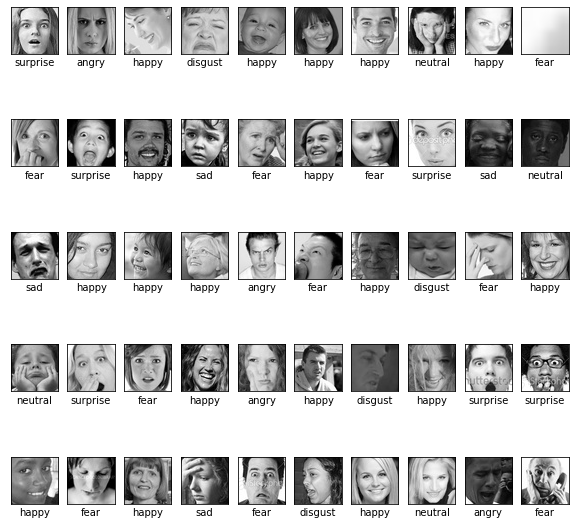

In [ ]:
#vamos a ver unas cuantas imagenes del set de entrenamiento
plt.figure(figsize=(10,10))
for i in range(50):
  plt.subplot(5,10,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(faces_train[i])
  plt.xlabel(dicc_labels[labels_train[i]])

Vemos que todas las imagenes estan dadas en blanco y negro anque en la forma conservan los 3 canales de colores RGB, tal vez no sea necesario conservar los tres canales y podríamos simplificar este aspecto. Vemos también que estan mezcladas las imagenes y no tenemos solo de un tipo de imagen. Vamos a analizar cuantas imagenes de cada etiqueta hay. Esto lo haremos con los Labels 

{'angry': 3321, 'disgust': 372, 'fear': 3417, 'happy': 5980, 'neutral': 4198, 'sad': 4058, 'surprise': 2698}


<BarContainer object of 7 artists>

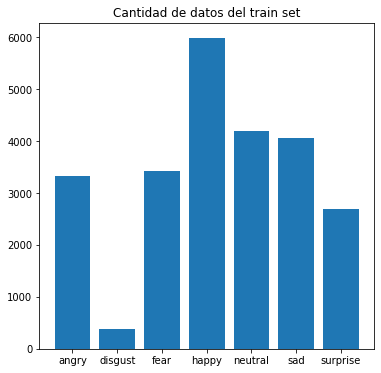

In [ ]:
unique,count=np.unique(labels_train,return_counts=True)
labels_uniq=[]
plt.figure(figsize=(6,6))
for i in unique:
  labels_uniq.append(dicc_labels[i])
print(dict(zip(labels_uniq,count)))
plt.title('Cantidad de datos del train set')
plt.bar(labels_uniq,count)

De este conteo, podemos concluir que hay muy pocas imagenes de expresiones de personas disgustadas, esto puede condicir a que mi red neoronal no reconozca muy bien a las personas disgustadas, y por el contrario las caras felices las va a predecir de mejor manera, ya que encuentra muchos datos. Podríamos trabajar con la cantidad de rostros de surprise y eliminar la etiqueda disgust, pero se perderian muchos datos en este proceso, incluyendo una etiqueta que queremos predecir.  

Text(0.5, 1.0, 'Cantidad de datos del train set')

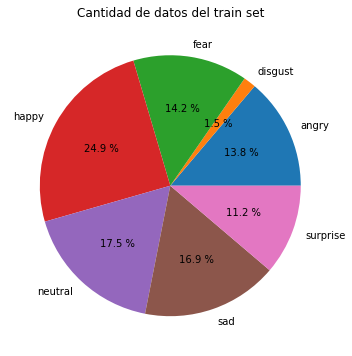

In [ ]:
plt.figure(figsize=(6,6))
plt.pie(count,labels=labels_uniq,autopct="%0.1f %%")
plt.title('Cantidad de datos del train set')

#Procesamiento de datos
Vamos a normalizar un poco las imagenes para crear mi red neuronal.

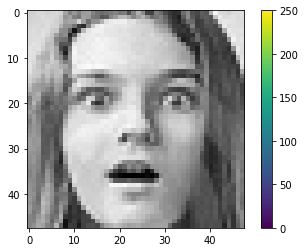

In [ ]:
#Visualicemos como se ve una imagen
plt.imshow(faces_train[0])
plt.colorbar()

Ya que las imagenes estan en escalas de grises, vamos a quitar los tres canales que traen por defecto, y convertimos las imagenes a escalas de grises. 

In [ ]:
#Vamos a definir una función que me convierta una imagen a color a una imagen de grises
def rgb2gray(rgb):
  return  np.dot (rgb [...,: 3], [0.299, 0.587, 0.114])

In [ ]:
gray_faces_train=rgb2gray(faces_train)
gray_faces_test=rgb2gray(faces_test)

Vamos a normalizarlas un poco más al cambiar la barra de colores de 0 a 250 a una escala de 0 a 1, con el fin de que mi red procese la información de mejor manera

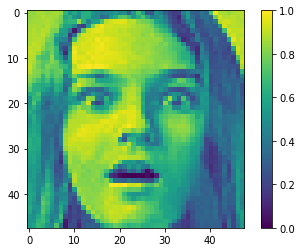

In [ ]:
gray_faces_test=gray_faces_test/250
gray_faces_train=gray_faces_train/250
plt.imshow(gray_faces_train[0])
plt.colorbar()

ahora como quitamos los 3 canales del RGB, vamos a dejar 1 canal para que no se pierda toda la información por completo y mi red pueda trabajar de mejor manera con un Cov2D (que es una red convolucional)

In [ ]:
gray_faces_train=gray_faces_train.reshape(len(faces_train),
                                          48,48,1)
gray_faces_test=gray_faces_test.reshape(len(faces_test),
                                        48,48,1)

In [ ]:
gray_faces_train.shape

(24044, 48, 48, 1)

#Creación del modelo y red neuronal


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(64, kernel_size=(3, 3),activation='relu',padding='same',
                        input_shape=(48,48,1)))


model.add(layers.Conv2D(128,
                     kernel_size=(3,3),
                     activation='relu',
                     padding='same',
           kernel_regularizer=regularizers.l2(0.01)))

model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size = (2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(256,
                     kernel_size=(3,3),
                     activation='relu',
                     padding='same',
           kernel_regularizer=regularizers.l2(0.01)))

model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(512,
                     kernel_size=(3,3),
                     activation='relu',
                     padding='same',
          kernel_regularizer=regularizers.l2(0.01)))

model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(512,
                     kernel_size=(3,3),
                     activation='relu',
                     padding='same',
          kernel_regularizer=regularizers.l2(0.01)))

model.add(layers.Dropout(0.25))
model.add(layers.Flatten())

model.add(layers.Dense(1024,activation='relu'))
model.add(layers.Dense(7,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 128)       73856     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 128)       512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 256)       295168    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 256)       1

In [ ]:
model.compile(optimizer='adagrad',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])


#Entrenamiento de la red neuronal

A la hora de entrenar la red neuronal, existen epochs que son mejores unas que otras, entonces guardaremos la epoca en la que mejor se desarrolle mi modelo, y es para esto que utilizamos la funcion callbacks.

In [ ]:
checkpoint_path='/content/drive/MyDrive/Analitica_de_datos/Analisis_de_expreciones_CNN/checkpoints/best_model'
cp_callbacks=tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                monitor='val_accuracy', 
                                                verbose=1, save_best_only=True, 
                                                mode='max')
model.fit(gray_faces_train,labels_train,
          epochs=50,
          validation_data=(gray_faces_test,labels_test),
          callbacks=[cp_callbacks])

In [ ]:
model=models.load_model('/content/drive/MyDrive/Analitica_de_datos/Analisis_de_expreciones_CNN/checkpoints/best_model')
#vamos a quedarnos con el mejor modelo

#Precisión del modelo y matriz de confusión

Vamos a ver que tan preciso fue el modelo junto con la matriz de confusión

In [ ]:
predictions=model.predict(gray_faces_test)

In [ ]:
test_loss,test_acc=model.evaluate(gray_faces_test,labels_test)

371/371 [==============================] - 3s 9ms/step - loss: 3.0745 - accuracy: 0.6066


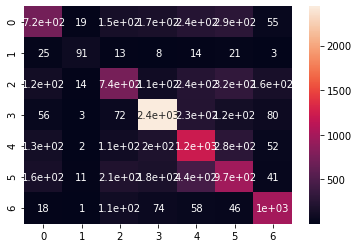

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix #nos ayudará a crear la matriz de confusión
predictargmax=np.argmax(predictions,axis=1)
mc=confusion_matrix(labels_test,predictargmax)
sns.heatmap(mc, annot=True)

La matriz de confusión nos ayuda a confirmar lo que suponíamos en el análisis de los datos. Con tan pocos datos sobre '2'=Disgust, mi red neuronal no reconoce de buena manera las personas disgustadas, en cambio '3'=Happy reconoce de una muy buena manera. además que tiende ha haber confución entre '4' y '5' que representan neutral y sad

#Guardamos el modelo
Al entrenar el modelo hemos guardado el mejor modelo y cargado el mejor modelo a través de un check point. Pero podemos guardar el modelo en un archivo json para traerlo de manera mas efectiva en el futuro, sin tener que entrenarlo de ceros. 

In [ ]:
model_json=model.to_json()
with open ('/content/drive/MyDrive/Analitica_de_datos/Analisis_de_expreciones_CNN/afrodita.json','w') as json_file:
  json_file.write(model_json)

model.save_weights('/content/drive/MyDrive/Analitica_de_datos/Analisis_de_expreciones_CNN/afrodita_weights.h5')

#El modelo se guardará con el nombre, afrodita (Diosa de la belleza)


#Cargar un modelo ya guardado.
Vamos ahora a cargar el modelo guardado previamente

In [ ]:
ruta_json='/content/drive/MyDrive/Analitica_de_datos/Analisis_de_expreciones_CNN/afrodita.json'
ruta_weights='/content/drive/MyDrive/Analitica_de_datos/Analisis_de_expreciones_CNN/afrodita_weights.h5'

json_file=open(ruta_json,'r')
json_model=json_file.read()
json_file.close()
model_load=models.model_from_json(json_model)
model_load.load_weights(ruta_weights)

#debemos volver a compilar nuestro modelo para poder dar la precisión
model_load.compile(optimizer='adagrad',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

Verificamos que la precisión siga manteteniendose

In [ ]:
test_loss,test_acc=model_load.evaluate(gray_faces_test,labels_test)

371/371 [==============================] - 5s 8ms/step - loss: 3.0840 - accuracy: 0.6055


#Pruebas para la red neuronal
Podemos realizar pruebas particulares con el set de testeo, también probar con imagenes de internet, o con imagenes propias que se quieran cargar. 

Primero realizaremos pruebas particulares con el set de pruebas

In [ ]:
numero_de_imagen=325
foto=np.array(gray_faces_test[numero_de_imagen])
x=np.zeros((1,48,48,1)) #demos redimensionar para poder probar la red

In [ ]:
x[0]=np.array(foto)

In [ ]:
result=model_load.predict(x) #damos la prediccion con la red cargada

In [ ]:
print('la foto numero ', numero_de_imagen,
      'expresa ', dicc_labels[np.argmax(result)],
      ' según nuestra predicción ')

la foto numero  325 expresa  happy  según nuestra predicción 


([], <a list of 0 Text major ticklabel objects>)

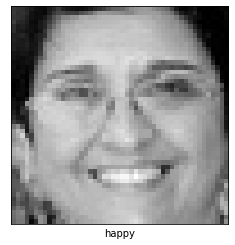

In [ ]:
plt.imshow(faces_test[numero_de_imagen])
plt.xlabel(dicc_labels[labels_test[numero_de_imagen]])
plt.xticks([])
plt.yticks([])

Ahora, probaremos con imagenes de internet o propias del usuario. Para esto construimos una función que amolde las imagenes a nuestra red entrenada

In [ ]:
def internet_image(url):
  response=requests.get(url)
  image=Image.open(BytesIO(response.content))
  array_img=np.array(image)
  return array_img

def predic_redef_image(ruta,internet_url=False):
  if internet_url:
    image=internet_image(ruta)
  else:
    imag=cv2.imread(ruta)
    image=np.array(imag)
  image_gray=rgb2gray(image)
  image_transform=cv2.resize(image_gray,dsize=(48,48),interpolation=cv2.INTER_CUBIC)
  image_reshape=image_transform.reshape(48,48,1)
  x=np.zeros((1,48,48,1))
  x[0]=np.array(image_reshape)
  result=model_load.predict(x)
  result=dicc_labels[np.argmax(result)]
  return [image,image_transform, result]

Text(0.5, 1.0, 'la prediccion de la expresión es: angry')

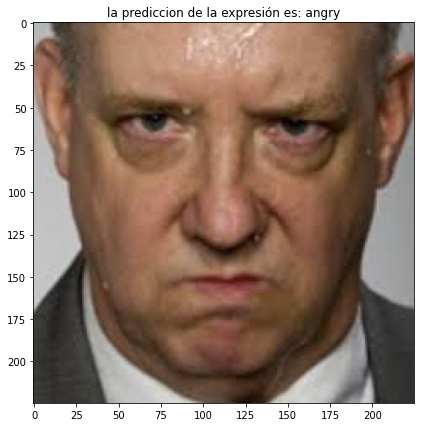

In [ ]:
url='https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSfumBIaNBRCD20qIV3psx33Ib9wNaOR9LSDA&usqp=CAU'
#url='https://a.wattpad.com/useravatar/KAELAAA_225.256.818670.jpg'
#url='https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTcS1RSkyqEKOj_kPa0MhB9hKo1ioBS3AkoAg&usqp=CAU'
#url='https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR69oO2TuAW6bNMrdUp6mQxQf2CajweAt-uzA&usqp=CAU'
#url='https://images.deepai.org/converted-papers/1605.03639/3_0.png'
image,image_transform,expresion=predic_redef_image(url,internet_url=True)
plt.figure(figsize=(7,7))
plt.imshow(image)
plt.title('la prediccion de la expresión es: '+str(expresion))

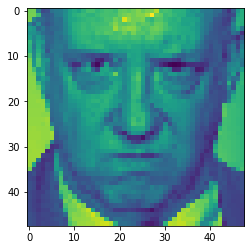

In [ ]:
plt.imshow(image_transform)

#Entrenamiento del modelo con datos modificados

Como vimos en el modelo anterior, el reconocimiento de las imagenes de disguts realmente no era muy bueno, por la poca cantidad de datos que se tenian de estas expresiones. Vamos a eliminar esta etiqueta, y vamos a intentar entrenar un modelo con el mismo tamaño de imagenes en los labels de las expresiones. Esto con el fin de observar si el modelo empeora o se vuelve mas eficas al entrenarlo. 

Primero cargaremos entonces los datos por defecto nuevamente y esta vez les haremos un tratamiento diferente. 

In [ ]:
#cargamos los datos como un arreglo, y creamos un diccionario de labels
faces,labels=load_data(faces_dir,Load_images=False)
dicc_labels={0:'angry',1:'disgust',2:'fear',3:'happy',4:'neutral',5:'sad',
           6:'surprise'}
value_origin=faces.shape[0]

antes de dividir los datos en datos de entrenamiento y de prueba, vamos a quitar las fotos que traen la etiqueta disgust y a dejar del mismo tamaño todas las fotos 

<BarContainer object of 7 artists>

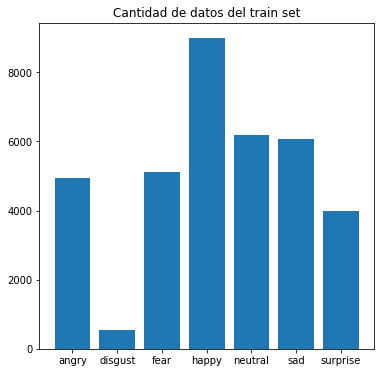

In [ ]:
unique,count=np.unique(labels,return_counts=True)
labels_uniq=[]
plt.figure(figsize=(6,6))
for i in unique:
  labels_uniq.append(dicc_labels[i])
dicc_count=dict(zip(labels_uniq,count))
plt.title('Cantidad de datos del train set')
plt.bar(labels_uniq,count)

vamos a eliminar todas las fotos de disgust

In [ ]:
faces=np.delete(faces,np.where(labels==1),0)
labels=np.delete(labels,np.where(labels==1))

<BarContainer object of 6 artists>

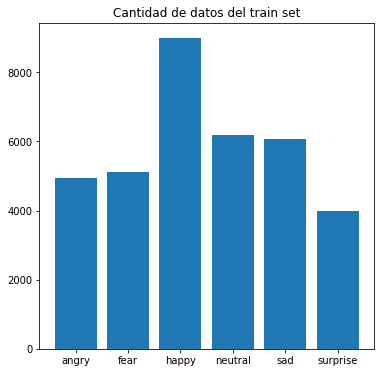

In [ ]:
unique,count=np.unique(labels,return_counts=True)
labels_uniq=[]
plt.figure(figsize=(6,6))
for i in unique:
  labels_uniq.append(dicc_labels[i])
dicc_count=dict(zip(labels_uniq,count))
plt.title('Cantidad de datos del train set')
plt.bar(labels_uniq,count)

Ahora dejemos los datos un poco mas nivelados. Para esto, hallaremos la media de todos los datos, y los que sobrepasen esa media, eliminaremos los datos. 

In [ ]:
values=dicc_count.values()
values=np.array(list(values))
data_mean=values.mean()
print('La cantidad media de fotos es ',data_mean)

La cantidad media de fotos es  5890.0


Vamos a eliminar las fotos que tienen mas de 5890

In [ ]:
angry=np.where(labels==0)[0]
fear=np.where(labels==2)[0]
happy=np.where(labels==3)[0]
neutral=np.where(labels==4)[0]
sad=np.where(labels==5)[0]
surprise=np.where(labels==6)[0]
expresions=[angry,fear,happy,neutral,sad,surprise]

for i in expresions:
  if len(i)>data_mean:
    random.shuffle(i)
    x=int(len(i)-data_mean)
    i=i[0:x]
    faces=np.delete(faces,i,0)
    labels=np.delete(labels,i)



<BarContainer object of 6 artists>

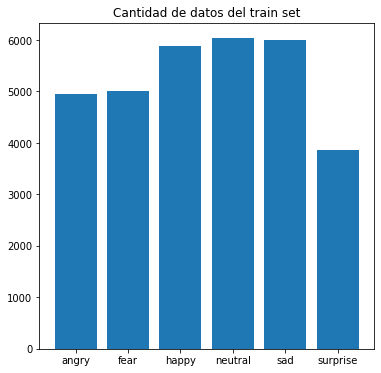

In [ ]:
unique,count=np.unique(labels,return_counts=True)
labels_uniq=[]
plt.figure(figsize=(6,6))
for i in unique:
  labels_uniq.append(dicc_labels[i])
dicc_count=dict(zip(labels_uniq,count))
plt.title('Cantidad de datos del train set')
plt.bar(labels_uniq,count)

In [ ]:
print(dicc_count)
value_modif=faces.shape[0]
print('hemos perdido ',value_origin-value_modif,' de ',value_origin,
      ' para obtener un valor de ',value_modif)

{'angry': 4953, 'fear': 5008, 'happy': 5890, 'neutral': 6036, 'sad': 6003, 'surprise': 3856}
hemos perdido  4141  de  35887  para obtener un valor de  31746


Aunque hemos perdidio una cantidad relevante de datos, la mayoría de la perdida estuvo en las caras happy, vamos a continuar con nuestro proceso. 

#Procesamiento de Datos modificado

In [ ]:
 #separamos la data en data de entrenamiento y de prueba
 faces_trainm, faces_testm, labels_trainm, labels_testm = train_test_split(
     faces, labels, test_size=0.33, random_state=42)
 #Acá el tamaño de los datos de prueba serán de un 33% de todos los datos en total
gray_faces_trainm=rgb2gray(faces_trainm)
gray_faces_testm=rgb2gray(faces_testm)
gray_faces_testm=gray_faces_testm/250
gray_faces_trainm=gray_faces_trainm/250
gray_faces_trainm=gray_faces_trainm.reshape(len(faces_trainm),
                                          48,48,1)
gray_faces_testm=gray_faces_testm.reshape(len(faces_testm),
                                        48,48,1)

In [ ]:
gray_faces_trainm.shape

(21269, 48, 48, 1)

#Creacion del Modelo con Datos modificados

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(64, kernel_size=(3, 3),activation='relu',padding='same',
                        input_shape=(48,48,1)))


model.add(layers.Conv2D(128,
                     kernel_size=(3,3),
                     activation='relu',
                     padding='same',
           kernel_regularizer=regularizers.l2(0.01)))

model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size = (2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(256,
                     kernel_size=(3,3),
                     activation='relu',
                     padding='same',
           kernel_regularizer=regularizers.l2(0.01)))

model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(512,
                     kernel_size=(3,3),
                     activation='relu',
                     padding='same',
          kernel_regularizer=regularizers.l2(0.01)))

model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(512,
                     kernel_size=(3,3),
                     activation='relu',
                     padding='same',
          kernel_regularizer=regularizers.l2(0.01)))

model.add(layers.Dropout(0.25))
model.add(layers.Flatten())

model.add(layers.Dense(1024,activation='relu'))
model.add(layers.Dense(7,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 128)       73856     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 128)       512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 256)       295168    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 256)       1

In [ ]:
model.compile(optimizer='adagrad',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])


In [ ]:
checkpoint_path='/content/drive/MyDrive/Analitica_de_datos/Analisis_de_expreciones_CNN/checkpoints/best_model_modific'
cp_callbacks=tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                monitor='val_accuracy', 
                                                verbose=1, save_best_only=True, 
                                                mode='max')
model.fit(gray_faces_trainm,labels_trainm,
          epochs=50,
          validation_data=(gray_faces_testm,labels_testm),
          callbacks=[cp_callbacks])

Epoch 1/50
665/665 [==============================] - 30s 34ms/step - loss: 12.7022 - accuracy: 0.2235 - val_loss: 12.0678 - val_accuracy: 0.2621

Epoch 00001: val_accuracy improved from -inf to 0.26210, saving model to /content/drive/MyDrive/Analitica_de_datos/Analisis_de_expreciones_CNN/checkpoints/best_model_modific
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Analitica_de_datos/Analisis_de_expreciones_CNN/checkpoints/best_model_modific/assets
Epoch 2/50
665/665 [==============================] - 22s 34ms/step - loss: 11.6861 - accuracy: 0.3206 - val_loss: 11.0698 - val_accuracy: 0.3652

Epoch 00002: val_accuracy improved from 0.26210 to 0.36518, saving model to /content/drive/MyDrive/Analitica_de_datos/Analisis_de_expreciones_CNN/checkpoints/best_model_modific
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Analitica_de_datos/Analisis_de_expreciones_CNN/checkpoints/best_model_modific/assets
Epoch 3/50
665/665 [==============================] - 23s 34ms/step -

In [ ]:
model_modificado=models.load_model('/content/drive/MyDrive/Analitica_de_datos/Analisis_de_expreciones_CNN/checkpoints/best_model_modific')
#vamos a quedarnos con el mejor modelo

#precisión del Modelo modificado

In [ ]:
predictions=model_modificado.predict(gray_faces_testm)
test_loss,test_acc=model.evaluate(gray_faces_testm,labels_testm)

328/328 [==============================] - 3s 8ms/step - loss: 2.3176 - accuracy: 0.5503


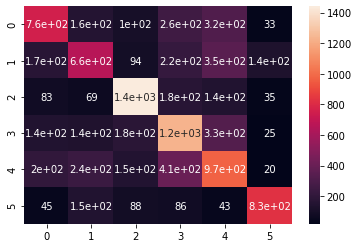

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix #nos ayudará a crear la matriz de confusión
predictargmax=np.argmax(predictions,axis=1)
mc=confusion_matrix(labels_testm,predictargmax)
sns.heatmap(mc, annot=True)

Vemos que aunque hayamos modificado los datos, para que no hubiera un desface tan grande, las caras felices son más sencillas de identificar para nuestro modelo. Además su precisión con respecto a los datos de pruba a bajado un 5%. En conclusión no resulta muy eficiente entrenar nuestra red con una modificación en los datos. 
 